## ToDo

- Optimization with `optuna` or `wandb`
- Supervised learning 
    - Annotate data 
    - Fit a neural network which takes as input the window and the annotated labels as targets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.environment import prepare_trading_env
from src.utils import load_config, display_env, plot_results
from src import optim

from stable_baselines3.common.vec_env import DummyVecEnv
from sb3_contrib.ppo_recurrent import RecurrentPPO

In [3]:
cfg = load_config("config.yaml")
cfg

{'env': {'ticker': 'ETH-USD',
  'interval': '1h',
  'period': '1y',
  'train_prop': 0.7,
  'window_size': 30,
  'indicators': ['MOM', 'MACD', 'MFI', 'RSI', 'ATR', 'CO', 'OBV']},
 'policy': {'net_arch': {'vf': [128, 128], 'pi': [128, 128]},
  'lstm_hidden_size': 128,
  'n_lstm_layers': 2},
 'ppo': {'batch_size': 64,
  'n_steps': 4,
  'gamma': 0.99,
  'n_epochs': 5,
  'clip_range': 0.2,
  'verbose': 0},
 'optim': {'n_episodes': 1,
  'max_no_improvement_evals': 3,
  'min_evals': 5,
  'save_path': 'models/ppo_eth_1y/'}}

In [4]:
env_train, env_test = prepare_trading_env(cfg["env"]) 

[*********************100%***********************]  1 of 1 completed


info: {'total_reward': 288.1285400390625, 'total_profit': 9.312060851600429e-05, 'position': 1}


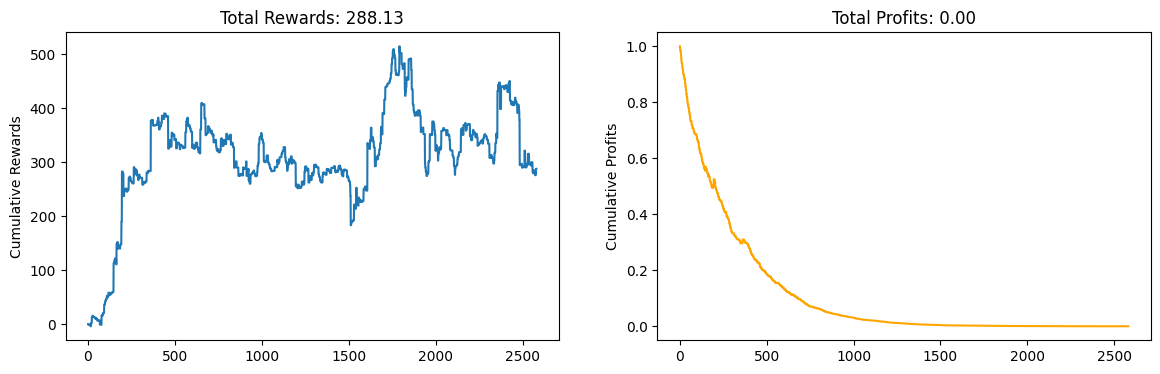

In [5]:
rewards, profits = env_test.run_episode()

plot_results(rewards, profits)

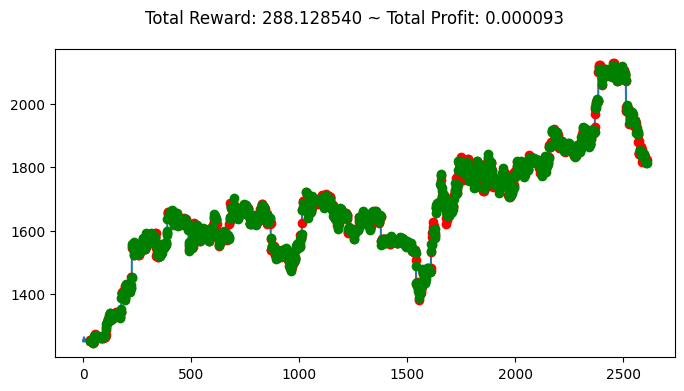

In [6]:
display_env(env_test)

In [7]:
env_train_maker = lambda: env_train
env_test_maker = lambda: env_test

# vectorize environment to pass it to the sb model
env_train_vec = DummyVecEnv(env_fns=[env_train_maker]) 

In [8]:
ppo = RecurrentPPO(
    policy="MlpLstmPolicy",
    env=env_train_vec,
    policy_kwargs=cfg["policy"],
    learning_rate=optim.linear_schedule(initial_value=.01),
    **cfg["ppo"]
)

In [9]:
ppo.policy

RecurrentActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=128, out_features=2, bias=True)
  (value_net): Linear(in_features=128, out_features=1, bias=True)
  (lstm_actor): LSTM(210, 128, num_layers=2)
  (lstm_critic): LSTM(210, 128, num_layers=2)
)

In [10]:
optim.train(ppo, env_train, cfg=cfg["optim"])

Output()

Eval num_timesteps=6064, episode_reward=0.00 +/- 0.00

Episode length: 6063.00 +/- 0.00

New best mean reward!

info: {'total_reward': 18.2705078125, 'total_profit': 0.9927295615483134, 'position': 1}


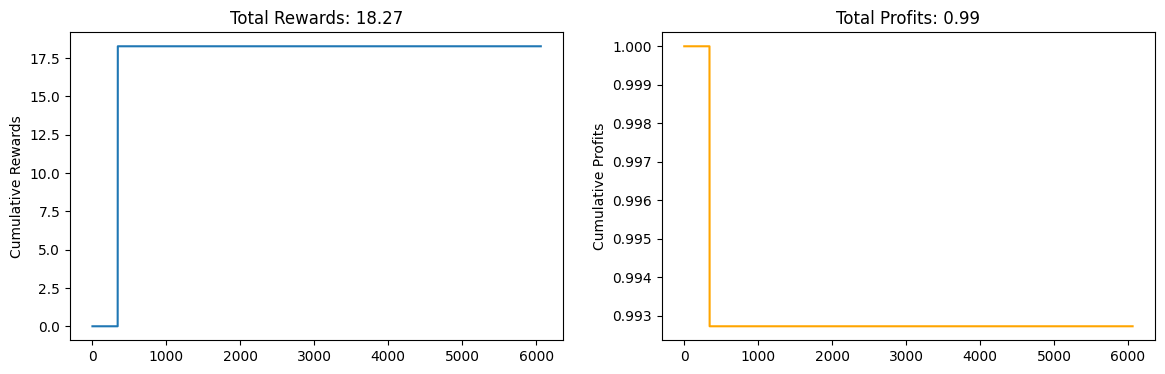

In [13]:
rewards, profits = env_train.run_episode(model=ppo)

plot_results(rewards, profits)

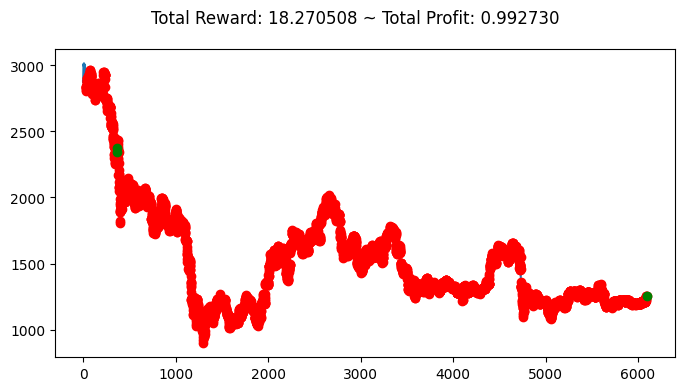

In [14]:
display_env(env_train)